# 🎧 Mixed-sample Augmentation

## Bibliotecas

In [60]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio
import os
import zipfile
import requests
from tqdm import tqdm

## Gerar áudios sintéticos 

In [61]:
#  Áudios sintéticos 
sr = 22050  # taxa de amostragem
duration = 3  # segundos
t = np.linspace(0, duration, int(sr*duration), endpoint=False)

# Áudio principal (vazamento sintético)
y_vazamento = 0.5 * np.sin(2 * np.pi * 440 * t)  # 440 Hz

# Áudio de ruído sintético 
y_ruido = 0.3 * np.random.randn(len(t))  # ruído branco

## Mistura de sinais

In [62]:
#  Mistura direta de sinais 
P_signal = np.mean(y_vazamento ** 2)
P_noise = np.mean(y_ruido ** 2)
SNR_dB = 10
alpha = np.sqrt((P_signal / P_noise) * 10 ** (-SNR_dB / 10))
y_mix = y_vazamento + alpha * y_ruido
y_mix = y_mix / np.max(np.abs(y_mix))
sf.write("saida_audio_misto_sintetico.wav", y_mix, sr)
print("✅ Mistura direta concluída (sintético)")

✅ Mistura direta concluída (sintético)


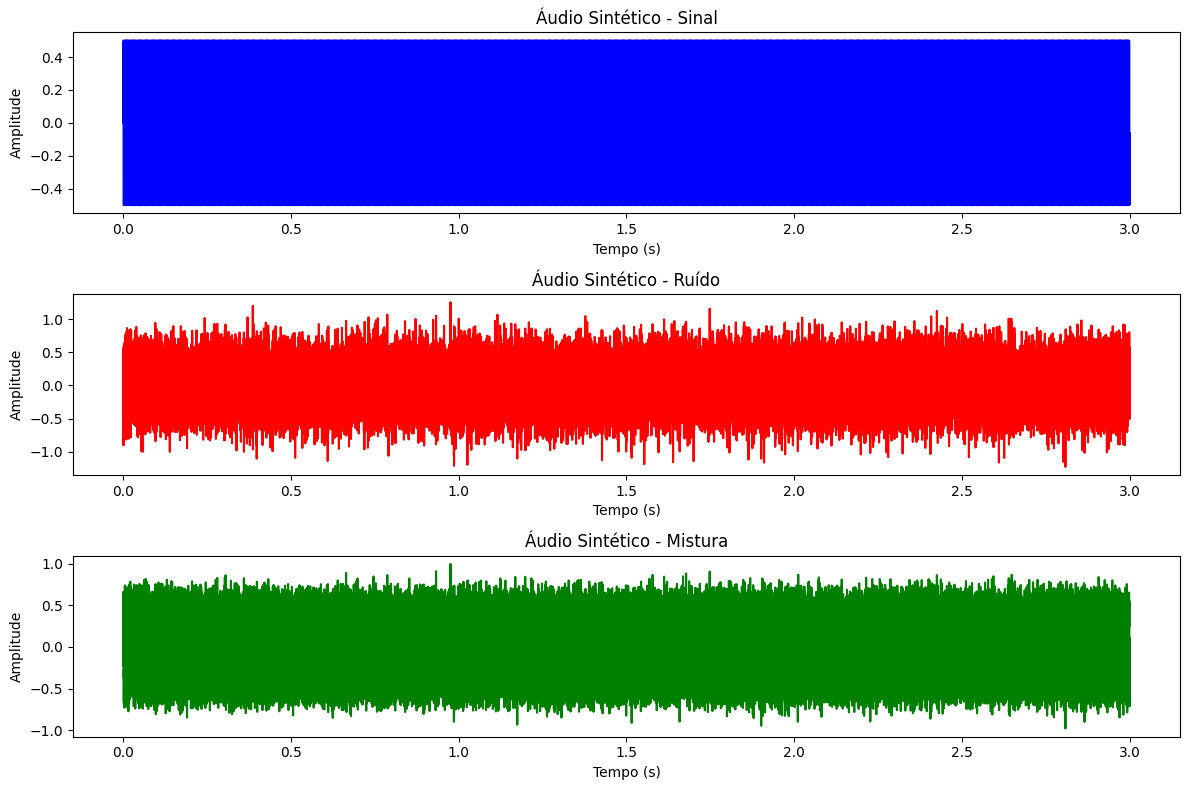

In [63]:
# Plot das formas de onda 
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, y_vazamento, color='blue')
plt.title("Áudio Sintético - Sinal")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 2)
plt.plot(t, y_ruido, color='red')
plt.title("Áudio Sintético - Ruído")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(3, 1, 3)
plt.plot(t, y_mix, color='green')
plt.title("Áudio Sintético - Mistura")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [64]:
print("🔊 Sinal")
display(Audio(y_vazamento, rate=sr))

print("🔊 Ruído")
display(Audio(y_ruido, rate=sr))

print("🔊 Mistura")
display(Audio(y_mix, rate=sr))

🔊 Sinal


🔊 Ruído


🔊 Mistura


## Mistura de espectrogramas

In [ ]:
S_vazamento = np.abs(librosa.stft(y_vazamento)) # transformando o áudio do domínio do tempo para o domínio da frequência
S_ruido = np.abs(librosa.stft(y_ruido))

# calcula potências médias
P_signal_spec = np.mean(S_vazamento ** 2)  
P_noise_spec = np.mean(S_ruido ** 2)

# alpha_spec é usado para escalar o espectrograma do ruído antes de somar ao sinal
alpha_spec = np.sqrt((P_signal_spec / P_noise_spec) * 10 ** (-SNR_dB / 10)) # fator de escala para o ruído

# soma o sinal principal com o ruído ajustado.
S_mix = S_vazamento + alpha_spec * S_ruido
phase = np.angle(librosa.stft(y_vazamento)) # pega a fase do sinal original
S_mix_complex = S_mix * np.exp(1j * phase)  # multiplicando a magnitude da mistura pela fase -> espectrograma complexo

y_mix_spec = librosa.istft(S_mix_complex)   # converte o espectrograma complexo de volta para sinal de áudio no tempo
y_mix_spec = y_mix_spec / np.max(np.abs(y_mix_spec))
sf.write("saida_espectrograma_misto_sintetico.wav", y_mix_spec, sr)
print("✅ Mistura espectral concluída (sintético)")


✅ Mistura espectral concluída (sintético)


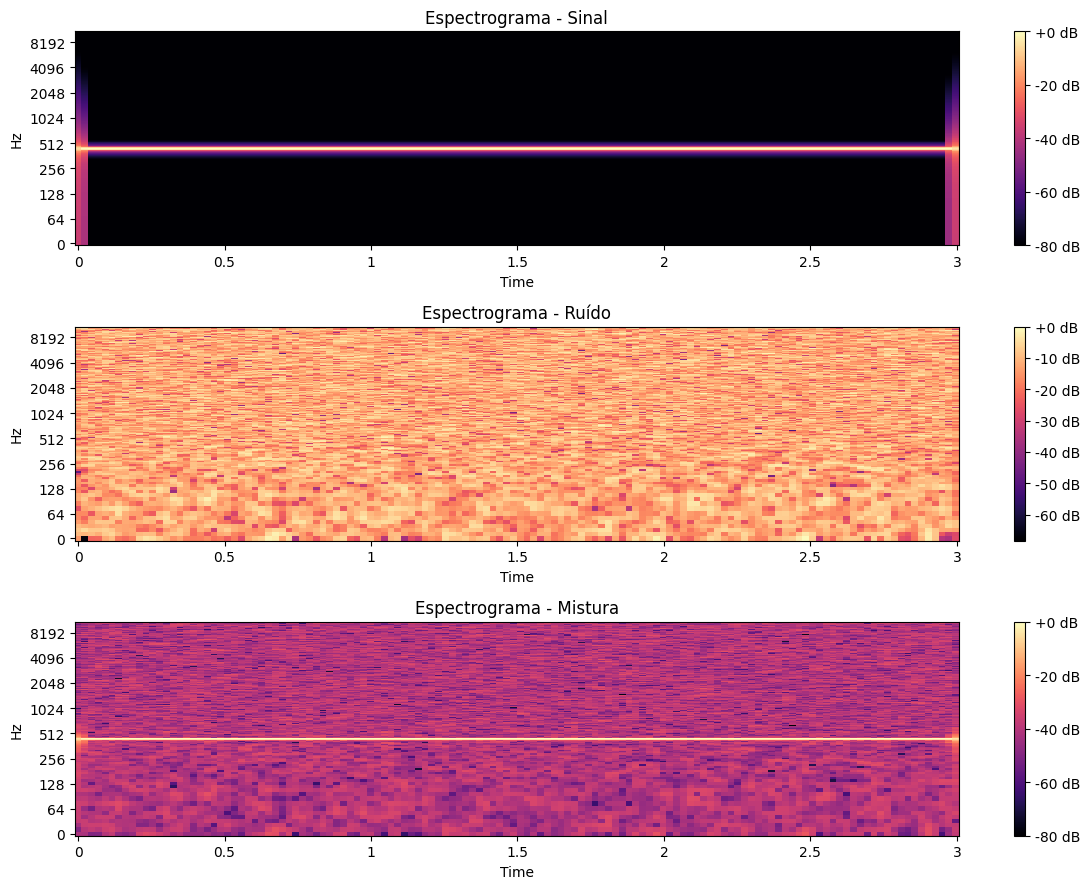

In [66]:
# Calcular espectrogramas 
S_vazamento = np.abs(librosa.stft(y_vazamento))
S_ruido = np.abs(librosa.stft(y_ruido))
S_mix = np.abs(librosa.stft(y_mix))

# Converter para escala logarítmica (dB)
S_db_vazamento = librosa.amplitude_to_db(S_vazamento, ref=np.max)
S_db_ruido = librosa.amplitude_to_db(S_ruido, ref=np.max)
S_db_mix = librosa.amplitude_to_db(S_mix, ref=np.max)

# Visualização dos espectrogramas
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(S_db_vazamento, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma - Sinal")

plt.subplot(3, 1, 2)
librosa.display.specshow(S_db_ruido, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma - Ruído")

plt.subplot(3, 1, 3)
librosa.display.specshow(S_db_mix, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma - Mistura")

plt.tight_layout()
plt.show()

# SpecMix: Mistura com Máscaras 

✅ SpecMix concluído e salvo como 'saida_specmix_sintetico.wav'


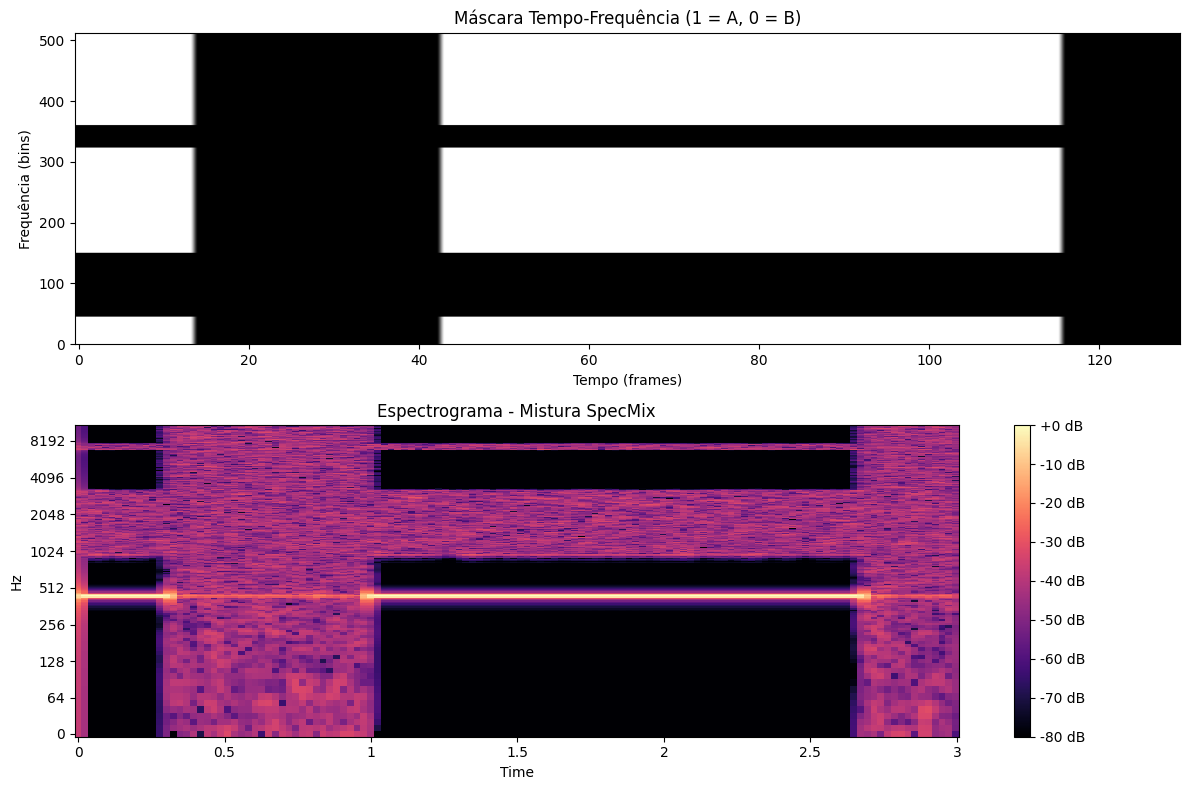

In [ ]:
# SpecMix: Mistura com Máscaras 
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from IPython.display import Audio

def specmix_audio(y_A, y_B, sr=22050, n_fft=1024, hop_length=512, gamma=0.3):
    """
    Implementação inspirada no paper SpecMix 
    Mistura seletiva de espectrogramas no domínio tempo-frequência.
    """
    # 1. STFT e magnitude 
    S_A = np.abs(librosa.stft(y_A, n_fft=n_fft, hop_length=hop_length))
    S_B = np.abs(librosa.stft(y_B, n_fft=n_fft, hop_length=hop_length))
    phase_A = np.angle(librosa.stft(y_A, n_fft=n_fft, hop_length=hop_length))
    F, T = S_A.shape

    # 2. Geração da máscara binária ===
    M = np.ones((F, T), dtype=np.float32)

    # --- Máscaras de frequência ---
    n_freq_bands = np.random.randint(1, 4)  # até 3 bandas
    for _ in range(n_freq_bands):
        f_start = np.random.randint(0, F)
        f_width = int(np.random.uniform(0, gamma) * F)
        f_end = np.clip(f_start + f_width, 0, F)
        M[f_start:f_end, :] = 0  # regiões substituídas por B

    # --- Máscaras de tempo ---
    n_time_bands = np.random.randint(1, 4)
    for _ in range(n_time_bands):
        t_start = np.random.randint(0, T)
        t_width = int(np.random.uniform(0, gamma) * T)
        t_end = np.clip(t_start + t_width, 0, T)
        M[:, t_start:t_end] = 0

    # 3. Mistura seletiva 
    S_mix = M * S_A + (1 - M) * S_B

    # 4. Reaplica fase e reconstrói 
    S_mix_complex = S_mix * np.exp(1j * phase_A)
    y_mix_specmix = librosa.istft(S_mix_complex, hop_length=hop_length)
    y_mix_specmix = y_mix_specmix / np.max(np.abs(y_mix_specmix))  # normalização

    return y_mix_specmix, M


# Aplicar SpecMix 
y_specmix, M = specmix_audio(y_vazamento, y_ruido, sr=sr, gamma=0.3)

# Salvar o áudio resultante
sf.write("saida_specmix_sintetico.wav", y_specmix, sr)
print("✅ SpecMix concluído e salvo como 'saida_specmix_sintetico.wav'")

# Visualizar máscara e espectrograma resultante
S_specmix = np.abs(librosa.stft(y_specmix))
S_db_specmix = librosa.amplitude_to_db(S_specmix, ref=np.max)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.imshow(M, origin='lower', aspect='auto', cmap='gray')
plt.title("Máscara Tempo-Frequência (1 = A, 0 = B)")
plt.xlabel("Tempo (frames)")
plt.ylabel("Frequência (bins)")

plt.subplot(2, 1, 2)
librosa.display.specshow(S_db_specmix, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Espectrograma - Mistura SpecMix")
plt.tight_layout()
plt.show()

In [68]:
# Ouvir resultado
print("🔊 Áudio resultante (SpecMix)")
display(Audio(y_specmix, rate=sr))

🔊 Áudio resultante (SpecMix)


# 🎧 Data Augmentation com Espectrogramas com ESC-50 

In [69]:
# Data Augmentation com Espectrogramas no ESC-50 

# 1. Baixar ESC-50 
esc50_url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
esc50_zip = "ESC-50.zip"
esc50_folder = "ESC-50-master/audio"

if not os.path.exists(esc50_folder):
    print("⬇️ Baixando dataset ESC-50 (~600 MB)...")
    with requests.get(esc50_url, stream=True) as r:
        total = int(r.headers.get('content-length', 0))
        with open(esc50_zip, 'wb') as f, tqdm(
            desc=esc50_zip, total=total, unit='iB', unit_scale=True
        ) as bar:
            for data in r.iter_content(chunk_size=1024):
                size = f.write(data)
                bar.update(size)

    # Extrair
    with zipfile.ZipFile(esc50_zip, 'r') as zip_ref:
        zip_ref.extractall()
    print("✅ Dataset ESC-50 extraído!")
  

In [ ]:
# 2. Selecionar dois exemplos -> https://github.com/karolpiczak/ESC-50/blob/master/meta/esc50.csv

audio_A_path = os.path.join(esc50_folder, "1-34094-A-5.wav")  # "miado" 
audio_B_path = os.path.join(esc50_folder, "1-26222-A-10.wav") # "chuva"

y_A, sr = librosa.load(audio_A_path, sr=None)
y_B, _ = librosa.load(audio_B_path, sr=sr)

# Ajustar comprimento
min_len = min(len(y_A), len(y_B))
y_A, y_B = y_A[:min_len], y_B[:min_len]

In [71]:
# 3. Mistura espectral com controle de SNR 
SNR_dB = 0   # relação sinal-ruído desejada em dB -> 0 = sinal e ruído com mesma potência, 10 = sinal 10x mais potente
S_A = np.abs(librosa.stft(y_A))             # Converter o áudio em espectrograma STFT
S_B = np.abs(librosa.stft(y_B))

P_signal_spec = np.mean(S_A ** 2)           # Potência média (energia) do sinal principal
P_noise_spec = np.mean(S_B ** 2)
alpha_spec = np.sqrt((P_signal_spec / P_noise_spec) * 10 ** (-SNR_dB / 10)) * 2.0   
# SNR -> Signal-to-Noise Ratio -> Mede o quanto o som útil se destaca em meio ao ruído

S_mix = S_A + alpha_spec * S_B              # Magnitudes dos dois sons * fator de mistura (α)
phase = np.angle(librosa.stft(y_A))
S_mix_complex = S_mix * np.exp(1j * phase)
y_mix_spec = librosa.istft(S_mix_complex)
y_mix_spec /= np.max(np.abs(y_mix_spec))

sf.write("esc50_misto.wav", y_mix_spec, sr)
print("✅ Mistura espectral concluída com SNR = 0 dB (ESC-50)")

✅ Mistura espectral concluída com SNR = 0 dB (ESC-50)


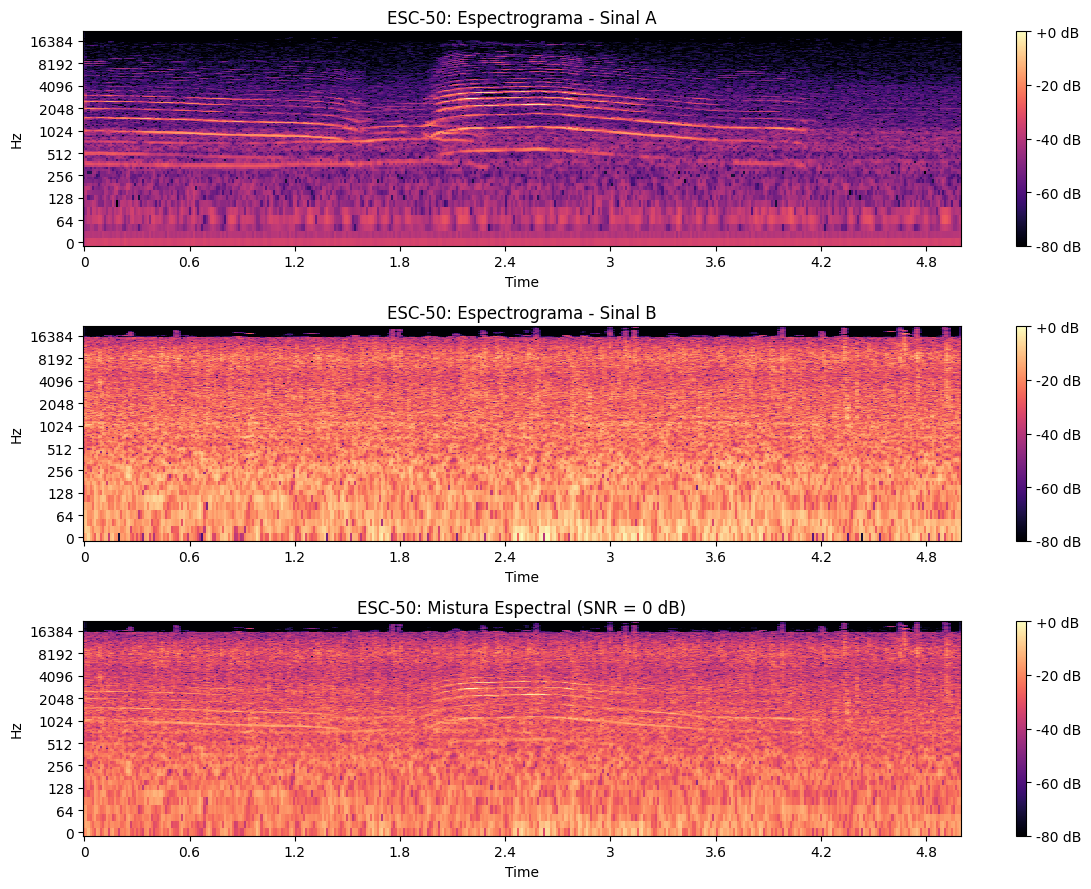

In [72]:
# 4. Espectrogramas comparativos 
S_db_A = librosa.amplitude_to_db(S_A, ref=np.max)
S_db_B = librosa.amplitude_to_db(S_B, ref=np.max)
S_db_mix = librosa.amplitude_to_db(S_mix, ref=np.max)

plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
librosa.display.specshow(S_db_A, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("ESC-50: Espectrograma - Sinal A")

plt.subplot(3, 1, 2)
librosa.display.specshow(S_db_B, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("ESC-50: Espectrograma - Sinal B")

plt.subplot(3, 1, 3)
librosa.display.specshow(S_db_mix, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("ESC-50: Mistura Espectral (SNR = 0 dB)")

plt.tight_layout()
plt.show()

In [73]:
# 5. Ouvir os áudios 
print("🔊 ESC-50 - Sinal A")
display(Audio(y_A, rate=sr))

print("🔊 ESC-50 - Sinal B")
display(Audio(y_B, rate=sr))

print("🔊 Mistura (Sinal A + Sinal B)")
display(Audio(y_mix_spec, rate=sr))


🔊 ESC-50 - Sinal A


🔊 ESC-50 - Sinal B


🔊 Mistura (Sinal A + Sinal B)


# Testes em andamento...

## Testes com as funções criadas:

In [74]:
from spectrogram_mix_functions import (
    mix_spectrograms,
    plot_spectrograms,
    plot_waveforms_and_audio
)

In [75]:
import os
import librosa

esc50_folder = "C:/Users/steva/OneDrive/Documentos/Codigos/ESC-50-master/audio"

# 2. Seleciona dois exemplos 
audio_A_path = os.path.join(esc50_folder, "1-29532-A-16.wav")  # "wind"
audio_B_path = os.path.join(esc50_folder, "1-32318-A-0.wav") # "dog"

y_target, sr = librosa.load(audio_A_path, sr=None)
y_noise, _ = librosa.load(audio_B_path, sr=sr)


In [76]:
y_mix, S_mix, alpha = mix_spectrograms(y_target, y_noise, sr, snr_db=5)

print(f"Fator alpha aplicado ao ruído: {alpha:.4f}")


Fator alpha aplicado ao ruído: 0.2542


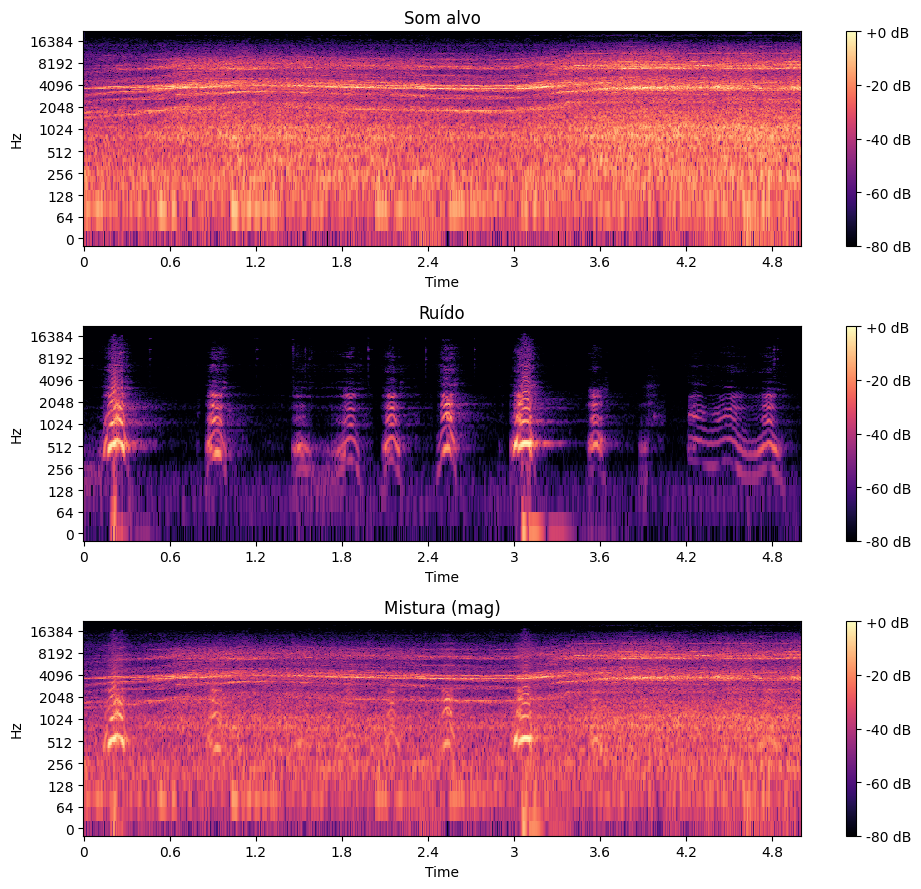

In [77]:
plot_spectrograms(
    [y_target, y_noise, S_mix],
    sr,
    titles=['Som alvo', 'Ruído', 'Mistura (mag)']
)

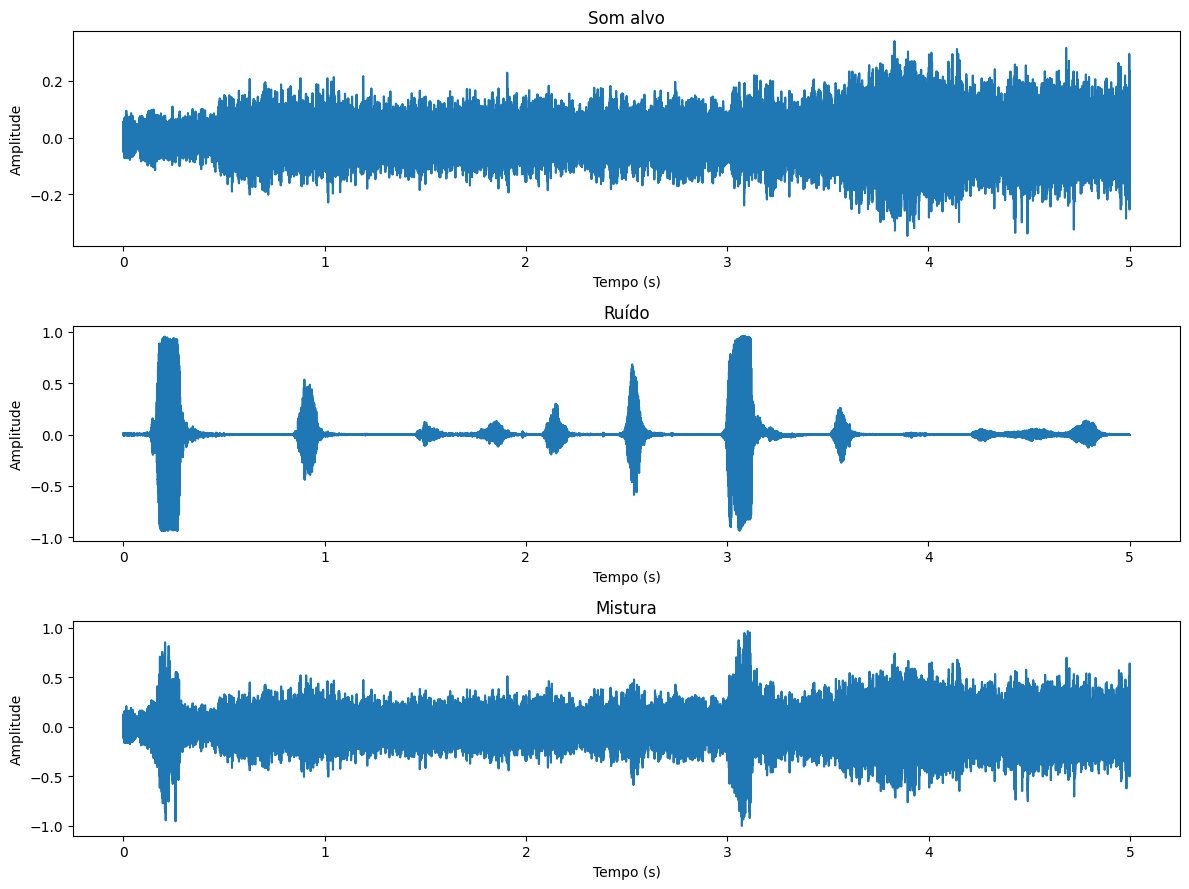

🔊 Som alvo


🔊 Ruído


🔊 Mistura


In [78]:
plot_waveforms_and_audio(
    [y_target, y_noise, y_mix],
    sr,
    titles=['Som alvo', 'Ruído', 'Mistura']
)